In [5]:
import numpy as np
import math
from scipy import fft
from scipy.interpolate import interp1d
from scipy.linalg import eig
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.colors import to_rgba
import os
import matplotlib.cm as cm

import seaborn as sns



def RK4(f, current_state: tuple, step_size: float = 0.01) -> float:
    """Performs Runge-Kunta 4th Order for a Single Step

    Args:
        f (_type_): A function.
        current_state (tuple): Inputs to the functions applicable
        step_size (float, optional): The step size used in RK4. Defaults to 0.01.

    Returns:
        float: A new value, f(current_state+step_size)
    """    
    k1 = step_size * f(*current_state)

    k2 = step_size * f(
        *[current_state[i] + k1 * 0.5 for i in range(len(current_state))]
    )
    k3 = step_size * f(
        *[current_state[i] + k2 * 0.5 for i in range(len(current_state))]
    )
    k4 = step_size * f(*[current_state[i] + k3 for i in range(len(current_state))])

    return (k1 + 2 * k2 + 2 * k3 + k4) / 6

class SIRbase:
    def __init__(self, beta: float, gamma: float, I0: float):
        """
        Initialize base SIR model with model parameters (beta, gamma) and initial conditions (I(0))
        """
        self.beta = beta
        self.gamma = gamma

        self.S = 1 - I0
        self.I = I0
        self.R = 0

    def dSdt(self, S, I) -> float:
        """
        Differential equation for susceptible population.
        """
        return -self.beta * S * I

    def dIdt(self, S, I) -> float:
        """
        Differential equation for infected population.
        """
        return self.beta * S * I - self.gamma * I

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method as implemented prior
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I

        self.R = 1 - self.S - self.I

    def numerical_integration(self, t: int, dt: float = 0.01):
        """Numerical Integration of the SIR model over time t using RK4 with step size dt.

        Args:
            t (int): Total time.
            dt (float, optional): Step size for RK4. Defaults to 0.01.

        Returns:
            Matrix of t, S, I, R

        """
        times = np.linspace(0, t, int(t / dt) + 1)
        S_values = [self.S]
        I_values = [self.I]
        R_values = [self.R]

        for _ in times[1:]:
            self.update_step(dt)
            S_values.append(self.S)
            I_values.append(self.I)
            R_values.append(self.R)

        return np.column_stack((times, S_values, I_values, R_values)).T
    
class SIRdemography(SIRbase):
    def __init__(self, beta: float, gamma: float, I0: float, mu: float):
        """
        Initialize SIR model with demography parameters
        """
        super().__init__(beta, gamma, I0)
        self.mu = mu

    def dSdt(self, S, I):
        """
        Differential equation for susceptible population including demography.
        """
        return self.mu - self.beta * S * I - self.mu * S

    def dIdt(self, S, I):
        """
        Differential equation for infected population including demography.
        """
        return self.beta * S * I - I * self.gamma - I*self.mu
    
    def dRdt(self, I, R):
        return self.gamma * I - self.mu * R

    def update_step(self, dt=0.01):
        """
        Perform step update using the Runge–Kutta method, including infection-induced mortality.
        """

        delta_S = RK4(self.dSdt, (self.S, self.I), step_size=dt)
        delta_I = RK4(self.dIdt, (self.S, self.I), step_size=dt)
        delta_R = RK4(self.dRdt, (self.I, self.R), step_size=dt)
        
        self.S += delta_S
        self.I += delta_I
        self.R += delta_R

def compute_period_oscillations(beta, gamma, mu):
    """
    Compute the period of oscillations for the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - The period of oscillations.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Compute parameters for oscillation period formula
    A = 1 / (mu * (reproductive_number - 1))
    G = 1 / (mu + gamma)
    
    # Return the oscillation period
    return 1 / (2 * math.pi * np.sqrt(A * G))


def decay_rate(beta, gamma, mu):
    """
    Compute the decay rate of oscillations in the system.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate

    Returns:
    - Decay rate.
    """
    reproductive_number = beta / (gamma + mu)
    
    # Return the decay rate
    return -(mu * reproductive_number / 2)

def eigenvalue_analysis(beta, gamma, mu):
    """
    Perform an eigenvalue analysis to assess the stability of the endemic equilibrium.

    Parameters:
    - beta: Infection rate
    - gamma: Recovery rate
    - mu: Birth/death rate
    
    Raises:
    - ValueError: If the reproductive number (R0) is less than or equal to 1.
    """
    reproductive_number = beta / (gamma + mu)

    # Ensure R0 > 1 for an endemic equilibrium
    if reproductive_number <= 1:
        raise ValueError("R0 must be greater than 1 for an endemic equilibrium.")
    
    # Calculate endemic equilibrium points
    S_equil = (gamma + mu) / beta
    I_equil = (mu / beta) * (reproductive_number - 1)

    # Construct the Jacobian matrix at the endemic equilibrium
    J = np.array([[-beta * I_equil - mu, -beta * S_equil],
                  [beta * I_equil, beta * S_equil - (gamma + mu)]])

    # Compute the eigenvalues of the Jacobian matrix
    eigenvalues, _ = eig(J)
    #print(f"Eigenvalues of the Jacobian: {eigenvalues}")
    
    # Check stability based on the real parts of the eigenvalues
    #if np.all(np.real(eigenvalues) < 0):
    #    print("The endemic equilibrium is stable.")
    #else:
    #    print("The endemic equilibrium is not stable.")

    # Check for damped oscillations based on the imaginary parts of the eigenvalues
    #if np.any(np.imag(eigenvalues) != 0):
    #    print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) with damped oscillations.")
    #    print(f"The system has an oscillation period of {compute_period_oscillations(beta, gamma, mu)} and decay rate of {decay_rate(beta, gamma, mu)}")
    #else:
    #    print(f"The system approaches the endemic equilibrium (S: {S_equil}, I: {I_equil}) without oscillations.")

    return [{S_equil, I_equil}, compute_period_oscillations(beta,gamma,mu), decay_rate(beta,gamma,mu)]

In [6]:
class GillespieFirstReaction:
    def __init__(self, discrete_event_model: dict, initial_state, model_parameters: dict):
        # Model Initialization for Algorithm
        self.model = discrete_event_model
        self.state = initial_state
        self.N = np.sum(initial_state)
        self.model_parameters = model_parameters

        # Track Evolution of Algorithm
        self.day = 0  
        self.times = [self.day]  
        self.history = [list(initial_state)]  

    def update_rates(self):
        # Unpack state and use
        S, I, R = self.state

        rates = {}
        for event, (rate, effect) in self.model.items():
            rates[event] = rate(S, I, R, self.N, **self.model_parameters)
        
        return rates
    
    def step(self):
        rates = self.update_rates()

        u = np.random.uniform(0, 1, size=len(rates))
        delta_t = -np.log(u) / np.array(list(rates.values()))

        min_index = np.argmin(delta_t)
        event = list(rates.keys())[min_index]

        self.day += delta_t[min_index]

        effect = self.model[event][1]
        self.state = [x + dx for x, dx in zip(self.state, effect)]

        # Store the results
        self.times.append(self.day)
        self.history.append(list(self.state))

    def run(self, max_days=100):
        while self.day < max_days:
            self.step()

        # Return time and history for plotting or further analysis
        return self.times, self.history
    

In [10]:
def multiple_runs(discrete_model, init_state, model_parameters, num_simulations, max_days, steps):
    # Wraps the above function to perform multiple simulations
    common_times = np.linspace(0, max_days, steps)

    final_S = []
    final_I = []
    final_R = []

    for simulation in range(num_simulations):
        model = GillespieFirstReaction(discrete_model, init_state, model_parameters)
        times, history = model.run(max_days=max_days)
        # Store all interpolated S, I, R values from each simulation
        interpolated_S_values = []
        interpolated_I_values = []
        interpolated_R_values = []

        # Interpolate for Infected (I)
        interp_func_I = interp1d(times, [state[1] for state in history], bounds_error=False, fill_value="extrapolate")
        interpolated_I = interp_func_I(common_times)
        interpolated_I_values.append(interpolated_I)

        # Interpolate for Susceptible (S)
        interp_func_S = interp1d(times, [state[0] for state in history], bounds_error=False, fill_value="extrapolate")
        interpolated_S = interp_func_S(common_times)
        interpolated_S_values.append(interpolated_S)
        
        # Interpolate for Recovered (R)
        interp_func_R = interp1d(times, [state[2] for state in history], bounds_error=False, fill_value="extrapolate")
        interpolated_R = interp_func_R(common_times)
        interpolated_R_values.append(interpolated_R)

        final_S.append(interpolated_S_values)
        final_I.append(interpolated_I_values)
        final_R.append(interpolated_R_values)

    return np.array(common_times), np.array(final_S), np.array(final_I), np.array(final_R)

In [13]:
# Store the SIR model as a dictionary (Event: Rate, Effect)
SIR_model = {
    "E_b": (lambda S, I, R, N, beta, gamma, mu: mu * N, [1, 0, 0]),                     
    "E_t": (lambda S, I, R, N, beta, gamma, mu: beta * (S * I / N), [-1, 1, 0]),  
    "E_r": (lambda S, I, R, N, beta, gamma, mu: gamma * I, [0, -1, 1]),                 
    "E_dX": (lambda S, I, R, N, beta, gamma, mu: mu * S, [-1, 0, 0]),                   
    "E_dY": (lambda S, I, R, N, beta, gamma, mu: mu * I, [0, -1, 0]),                   
    "E_dR": (lambda S, I, R, N, beta, gamma, mu: mu * R, [0, 0, -1])                    
}

SIR_state = [990, 10, 0]
SIR_params = {
    'beta': 1,  
    'gamma': 0.3,  
    'mu': 1/100 
}

#time_stoch, S_stoch, I_stoch = multiple_runs(SIR_model, SIR_state,SIR_params, 50, 200, 500)

In [14]:
"""# Parameters
beta = 1
gamma = 0.3
mu = 1 / 20

# Color scheme
colors = {
    'Susceptible': '#ffbe30',
    'Exposed': '#fbcc98',
    'Infected': '#d62728',
    'Recovered': '#f857c1'
}

# Simulation settings
endemic_t = 200
endemic_dt = 0.005

# Run the demographic SIR model
t, S, I, R = SIRdemography(beta, gamma, 0.01, mu).numerical_integration(t=endemic_t, dt=endemic_dt)

# Calculate mean and standard deviation from stochastic simulations
mean_I = np.mean(I_stoch, axis=0)
std_I = np.std(I_stoch, axis=0)

# Plotting
plt.figure(dpi=300)

# Plot deterministic infected population
plt.plot(t, I, color=colors['Infected'], label='Infected')

# Plot the mean infected curve from stochastic simulations
plt.plot(time_stoch, mean_I[0] / 1000, color=colors['Recovered'], lw=2, alpha=0.5, label='Mean Infected')

# Plot the 95% confidence interval
plt.fill_between(
    time_stoch,
    (mean_I[0] - 1.96 * std_I[0]) / 1000,
    (mean_I[0] + 1.96 * std_I[0]) / 1000,
    color='gray', alpha=0.3, label='95% CI range'
)

# Axis labels and scaling
plt.xlabel('Time', fontsize=12)
plt.ylabel('Population fraction', fontsize=12)
plt.yscale('log')

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Display legend and finalize plot
plt.legend()
plt.tight_layout()
plt.show()
"""

"# Parameters\nbeta = 1\ngamma = 0.3\nmu = 1 / 20\n\n# Color scheme\ncolors = {\n    'Susceptible': '#ffbe30',\n    'Exposed': '#fbcc98',\n    'Infected': '#d62728',\n    'Recovered': '#f857c1'\n}\n\n# Simulation settings\nendemic_t = 200\nendemic_dt = 0.005\n\n# Run the demographic SIR model\nt, S, I, R = SIRdemography(beta, gamma, 0.01, mu).numerical_integration(t=endemic_t, dt=endemic_dt)\n\n# Calculate mean and standard deviation from stochastic simulations\nmean_I = np.mean(I_stoch, axis=0)\nstd_I = np.std(I_stoch, axis=0)\n\n# Plotting\nplt.figure(dpi=300)\n\n# Plot deterministic infected population\nplt.plot(t, I, color=colors['Infected'], label='Infected')\n\n# Plot the mean infected curve from stochastic simulations\nplt.plot(time_stoch, mean_I[0] / 1000, color=colors['Recovered'], lw=2, alpha=0.5, label='Mean Infected')\n\n# Plot the 95% confidence interval\nplt.fill_between(\n    time_stoch,\n    (mean_I[0] - 1.96 * std_I[0]) / 1000,\n    (mean_I[0] + 1.96 * std_I[0]) / 1000

In [15]:
def deterministic_SIR_with_demography(t, y, beta, gamma, mu):
    S, I, R = y
    N = S + I + R  
    dS_dt = mu * N - beta * S * I / N - mu * S   # Births into S, deaths from S
    dI_dt = beta * S * I / N - gamma * I - mu * I  # Infection, recovery, deaths from I
    dR_dt = gamma * I - mu * R  # Recovery, deaths from R
    return [dS_dt, dI_dt, dR_dt]

# Run deterministic SIR for comparison, with mu (demography)
def run_deterministic_SIR(init_state, beta, gamma, mu, max_days):
    t_span = (0, max_days)
    t_eval = np.linspace(0, max_days, 500)
    sol = solve_ivp(deterministic_SIR_with_demography, t_span, init_state, args=(beta, gamma, mu), t_eval=t_eval)
    return sol.t, sol.y

/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


For Gamma=0.2, Beta=1, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 11.3948
Mean Absolute Difference (I) = 1.9225

For Gamma=0.4, Beta=1, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 175.2158
Mean Absolute Difference (I) = 12.7401

For Gamma=0.6, Beta=1, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 107.1595
Mean Absolute Difference (I) = 5.9520



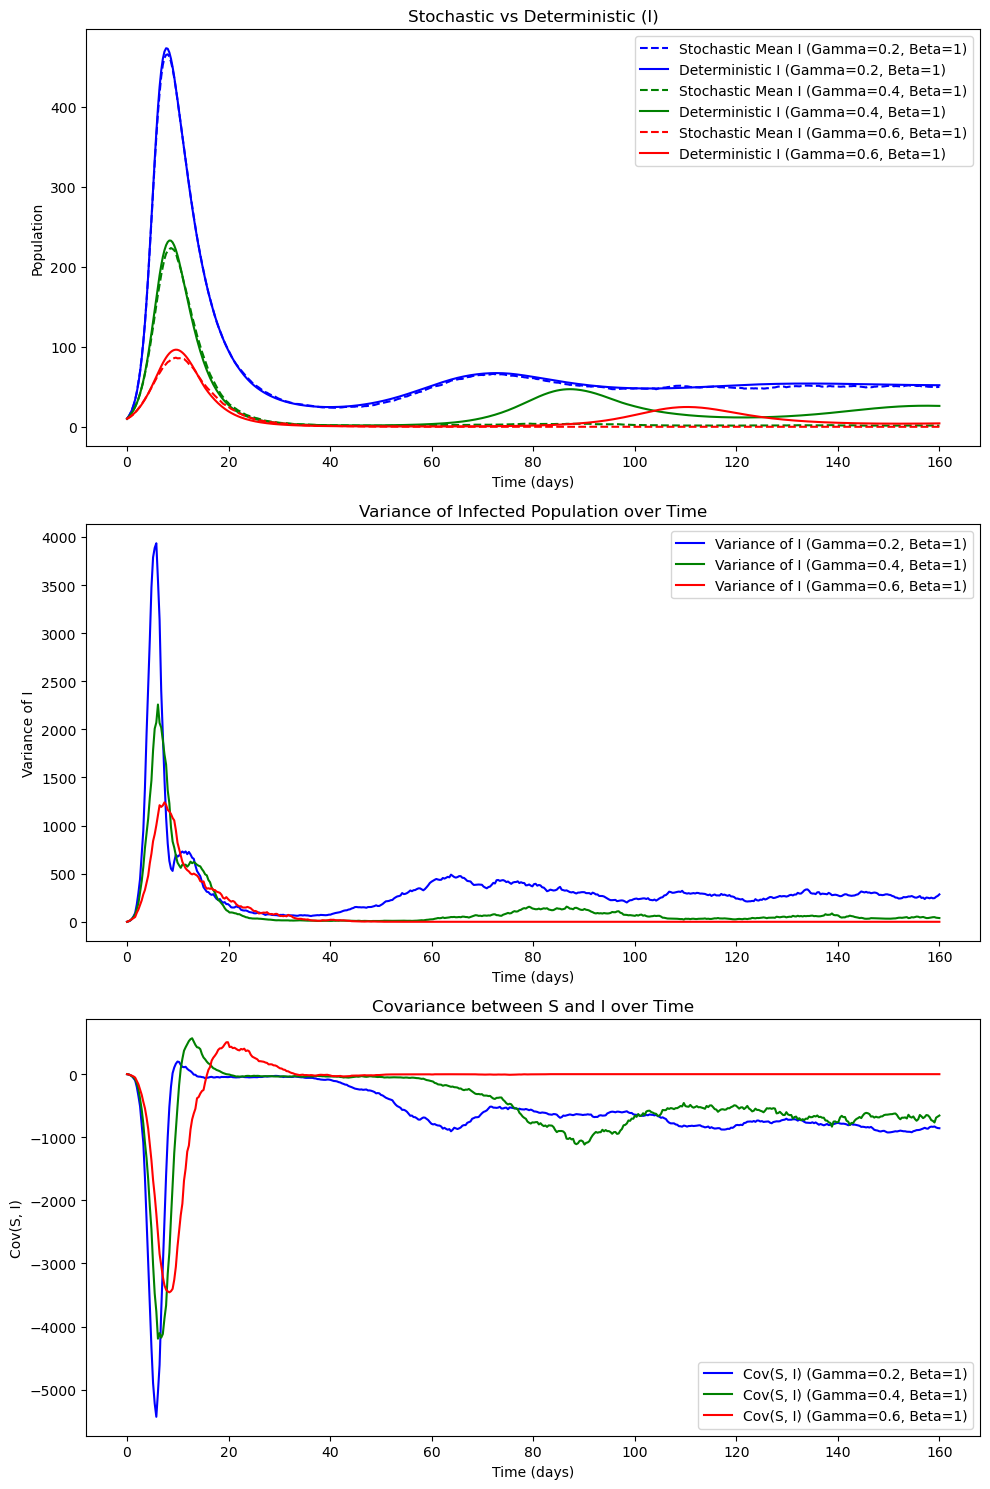

In [16]:

# Function to calculate the mean absolute difference between stochastic and deterministic values
def calculate_mean_difference(stochastic_mean, deterministic):
    return np.mean(np.abs(stochastic_mean - deterministic))

# Modified SASIR function to include calculation of mean difference
def SASIR(model_parameters, init_state, num_simulation, max_days):
    # Store results for plotting
    results = {
        'mean_S': [],
        'mean_I': [],
        'variances_I': [],
        'covariances_SI': [],
        'time_stochastic': [],
        'time_deterministic': [],
        'S_det': [],
        'I_det': [],
        'labels': []
    }
    constant_params = {key: value for key, value in model_parameters.items() if not isinstance(value, np.ndarray)}
    varrying_param = [key for key, value in model_parameters.items() if key not in constant_params][0]
    varying_values = model_parameters[varrying_param] 

    for value in varying_values:
        # Create a combination of parameters
        combination = {**constant_params, varrying_param: value}
        
        # Run stochastic SIR model multiple times
        time_stochastic, final_S, final_I, final_R = multiple_runs(SIR_model, init_state, combination, num_simulations=num_simulation, max_days=max_days, steps=500)

        # Squeeze the extra dimension from final_S and final_I
        final_S = np.squeeze(final_S)
        final_I = np.squeeze(final_I)

        # Calculate mean S and I for stochastic simulations
        mean_S = np.mean(final_S, axis=0)
        mean_I = np.mean(final_I, axis=0)

        # Solve deterministic model for comparison
        time_deterministic, sol_deterministic = run_deterministic_SIR(init_state, combination['beta'], combination['gamma'], combination['mu'], max_days)
        S_det, I_det = sol_deterministic[0], sol_deterministic[1]

        # Calculate the mean absolute difference for S and I
        mean_diff_S = calculate_mean_difference(mean_S, S_det)
        mean_diff_I = calculate_mean_difference(mean_I, I_det)

        # Print the mean differences for this parameter set
        print(f"For Gamma={combination['gamma']}, Beta={combination['beta']}, Mu={combination['mu']}:")
        print(f"Mean Absolute Difference (S) = {mean_diff_S:.4f}")
        print(f"Mean Absolute Difference (I) = {mean_diff_I:.4f}\n")

        # Calculate variance of I across simulations at each time point
        variances_I = np.var(final_I, axis=0)

        # Calculate covariance between S and I across simulations at each time point
        covariances_SI = [np.cov(final_S[:, t], final_I[:, t])[0, 1] for t in range(final_S.shape[1])]

        # Store the results for plotting
        results['mean_S'].append(mean_S)
        results['mean_I'].append(mean_I)
        results['variances_I'].append(variances_I)
        results['covariances_SI'].append(covariances_SI)
        results['time_stochastic'].append(time_stochastic)
        results['time_deterministic'].append(time_deterministic)
        results['S_det'].append(S_det)
        results['I_det'].append(I_det)
        results['labels'].append(f"Gamma={combination['gamma']}, Beta={combination['beta']}")
    # Call plotting function for all parameter combinations
    plot_combined_results(results)
    

# Function to plot combined results for multiple gamma values
def plot_combined_results(results):
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Colors for the different gamma values
    colors = ['blue', 'green', 'red']

    for i in range(len(results['labels'])):
        axs[0].plot(results['time_stochastic'][i], results['mean_I'][i], label=f'Stochastic Mean I ({results["labels"][i]})', linestyle='--', color=colors[i])
        axs[0].plot(results['time_deterministic'][i], results['I_det'][i], label=f'Deterministic I ({results["labels"][i]})', color=colors[i])

    axs[0].set_xlabel('Time (days)')
    axs[0].set_ylabel('Population')
    axs[0].set_title('Stochastic vs Deterministic (I)')
    axs[0].legend()

    # Plot variance of I over time for each gamma value
    for i in range(len(results['labels'])):
        axs[1].plot(results['time_stochastic'][i], results['variances_I'][i], label=f'Variance of I ({results["labels"][i]})', color=colors[i])

    axs[1].set_xlabel('Time (days)')
    axs[1].set_ylabel('Variance of I')
    axs[1].set_title('Variance of Infected Population over Time')
    axs[1].legend()

    # Plot covariance between S and I over time for each gamma value
    for i in range(len(results['labels'])):
        axs[2].plot(results['time_stochastic'][i], results['covariances_SI'][i], label=f'Cov(S, I) ({results["labels"][i]})', color=colors[i])

    axs[2].set_xlabel('Time (days)')
    axs[2].set_ylabel('Cov(S, I)')
    axs[2].set_title('Covariance between S and I over Time')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# Model parameters
model_parameters = {
    'beta': 1,  
    'gamma': np.array([0.2,0.4, 0.6]),  
    'mu': (1/70)  # Adding mu to the model parameters
}

# Initial state: [Susceptible, Infected, Recovered]
init_state = [990, 10, 0]  # Starting with 990 susceptible, 10 infected, and 0 recovered individuals

# Number of simulations and max days
num_simulation = 100  # Run 100 stochastic simulations
max_days = 160  # Simulate for 160 days

# Call the SASIR function to generate the plots and print mean differences
SASIR(model_parameters, init_state, num_simulation, max_days)


##### As $\gamma $(recovery rate) increases, the stochastic simulations deviate more from the deterministic model, the variance of I(t) decreases, and the negative covariance between S and I less pronounced. Conversely, a lower $\gamma$leads to a higher variance and a more negative covariance, with the stochastic simulations aligning more closely with the deterministic model This behavior makes sense because a higher $\gamma$ means individuals recover more quickly, which results in fewer infected individuals at any given time. With a smaller infected population, stochastic effects (randomness) become more prominent, causing greater deviation from the deterministic model. Faster recovery also means less time for variability to build up, leading to a lower peak in the variance of 
I
(
t
)
I(t). Additionally, since the infection spreads and resolves more quickly with a higher 
γ
γ, the inverse relationship between 
S
S and 
I
I is weaker, resulting in a less negative covariance.

/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


For Gamma=0.1, Beta=0.2, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 12.5022
Mean Absolute Difference (I) = 3.0783

For Gamma=0.1, Beta=0.5, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 3.0741
Mean Absolute Difference (I) = 1.7883

For Gamma=0.1, Beta=2.0, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 0.9854
Mean Absolute Difference (I) = 1.0403



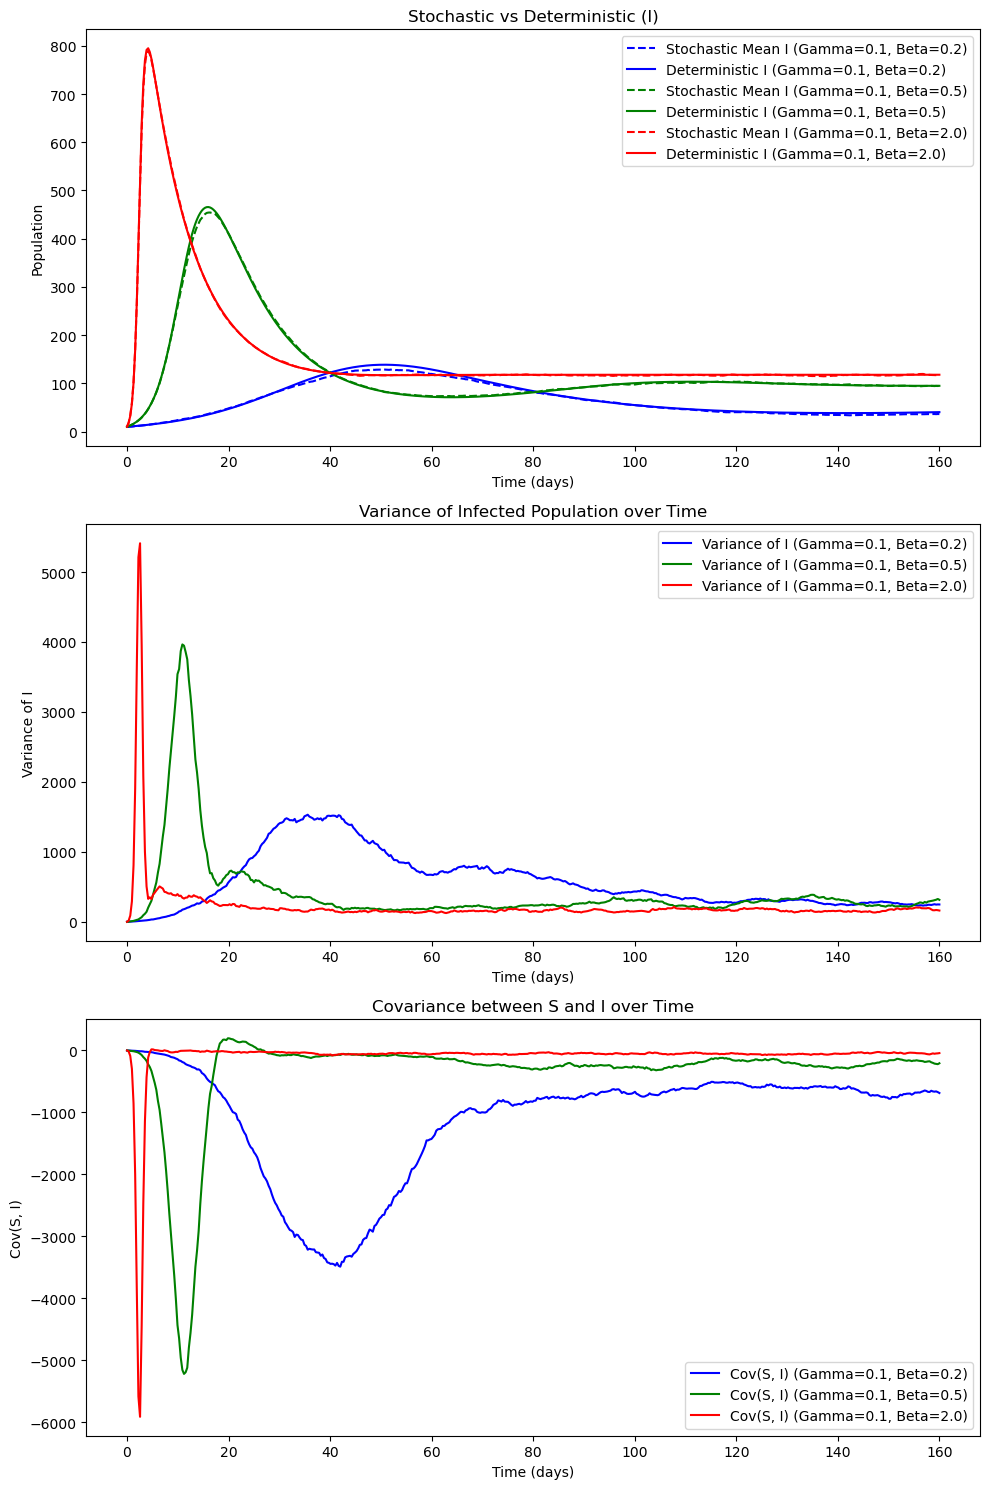

In [17]:
model_parameters = {
    'beta': np.array([0.2, 0.5, 2.0]),  # Example: varying beta
    'gamma': 0.1,  
    'mu': (1/70)  # Assumed birth/death rate
}

# Initial state: [Susceptible, Infected, Recovered]
init_state = [990, 10, 0]  # Starting with 990 susceptible, 10 infected, and 0 recovered individuals

# Number of simulations and max days
num_simulation = 100  # Run 100 stochastic simulations
max_days = 160  # Simulate for 160 days

# Call the SASIR function to generate the plots
SASIR(model_parameters, init_state, num_simulation, max_days)

/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


For Gamma=0.3, Beta=1, Mu=0.014285714285714285:
Mean Absolute Difference (S) = 151.3507
Mean Absolute Difference (I) = 14.3147

For Gamma=0.3, Beta=1, Mu=0.02:
Mean Absolute Difference (S) = 51.1887
Mean Absolute Difference (I) = 5.7626

For Gamma=0.3, Beta=1, Mu=0.03333333333333333:
Mean Absolute Difference (S) = 5.7929
Mean Absolute Difference (I) = 2.1730



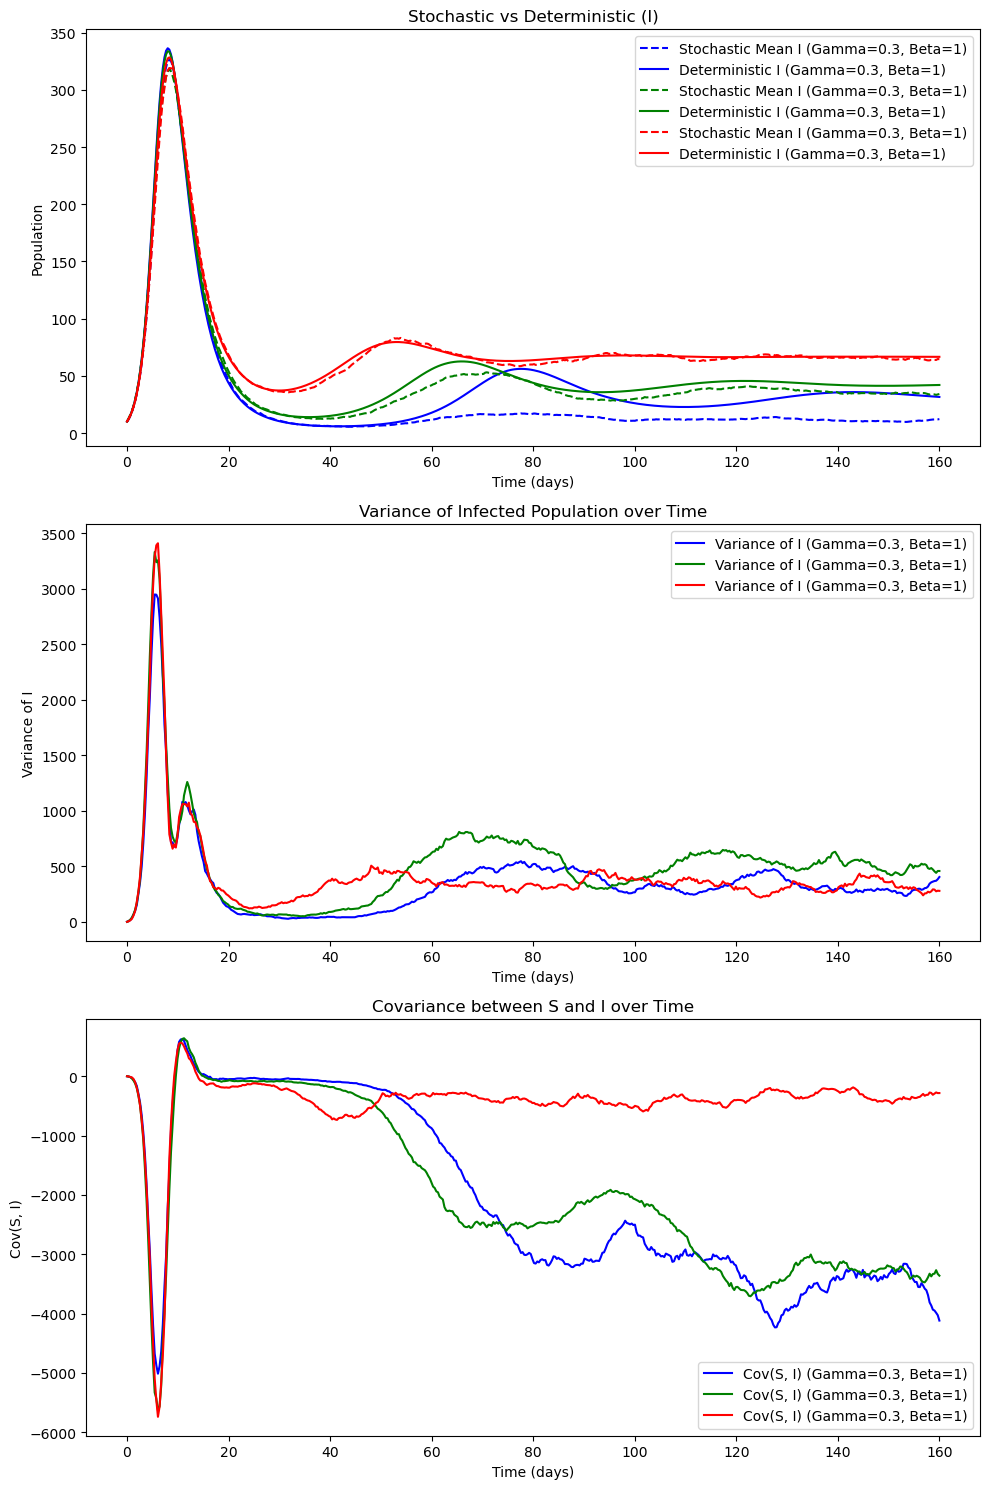

In [18]:
model_parameters = {
    'beta': 1,  # Example: varying beta
    'gamma': 0.3,  
    'mu': np.array([(1/70), (1/50), (1/30)]) # Assumed birth/death rate
}
SASIR(model_parameters, init_state, num_simulation, max_days)

##### So when beta is bigger and when gamma is smaller there is more variance in data and a bigger covariance so when $R_0 = \frac{\beta}{\gamma} $ is bigger there is more variance in the data and there is a stronger covariance between I and S. increases the variance in the number of infected people across multiple runs because the faster transmission makes the system more sensitive to small stochastic differences. Higher $R_0$ leads to stronger covariance between I and S because the dynamics of infections and susceptible depletion are more closely tied as the epidemic progresses quickly in a population.

/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


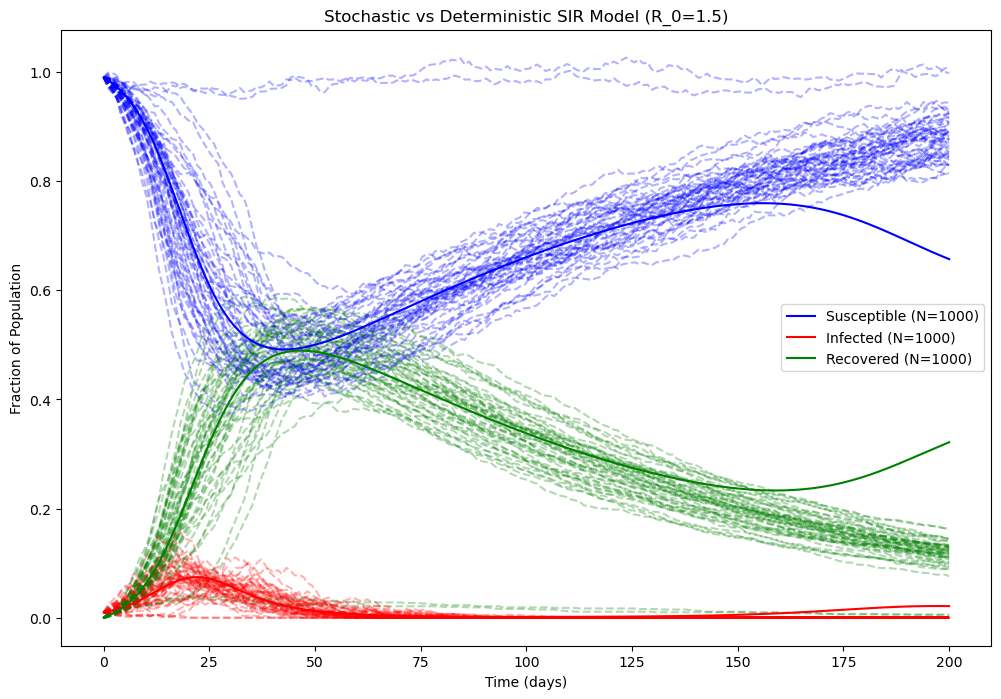

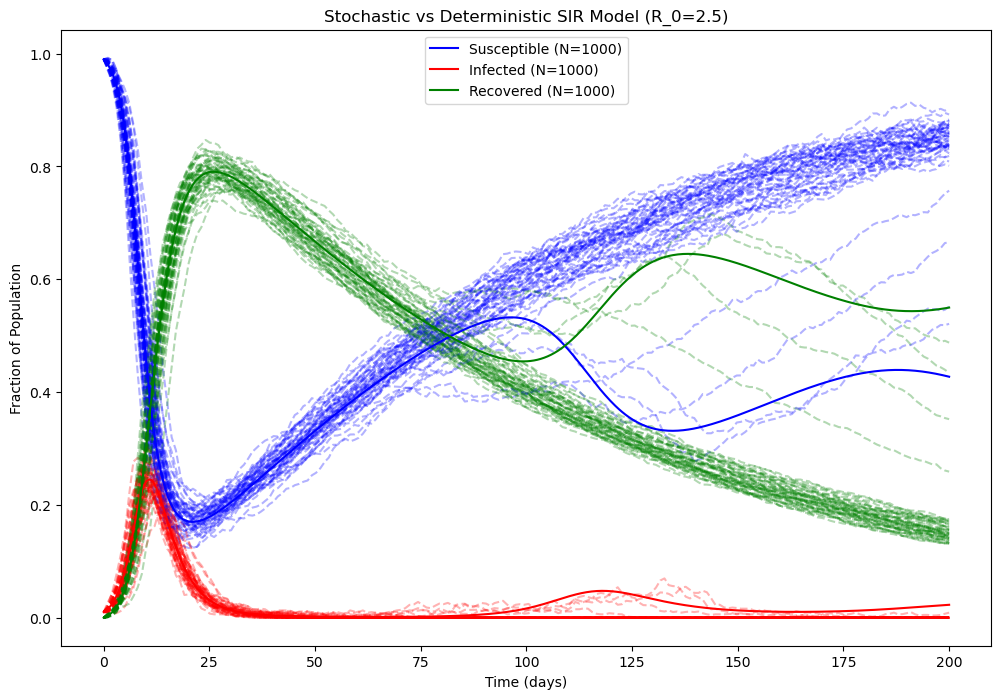

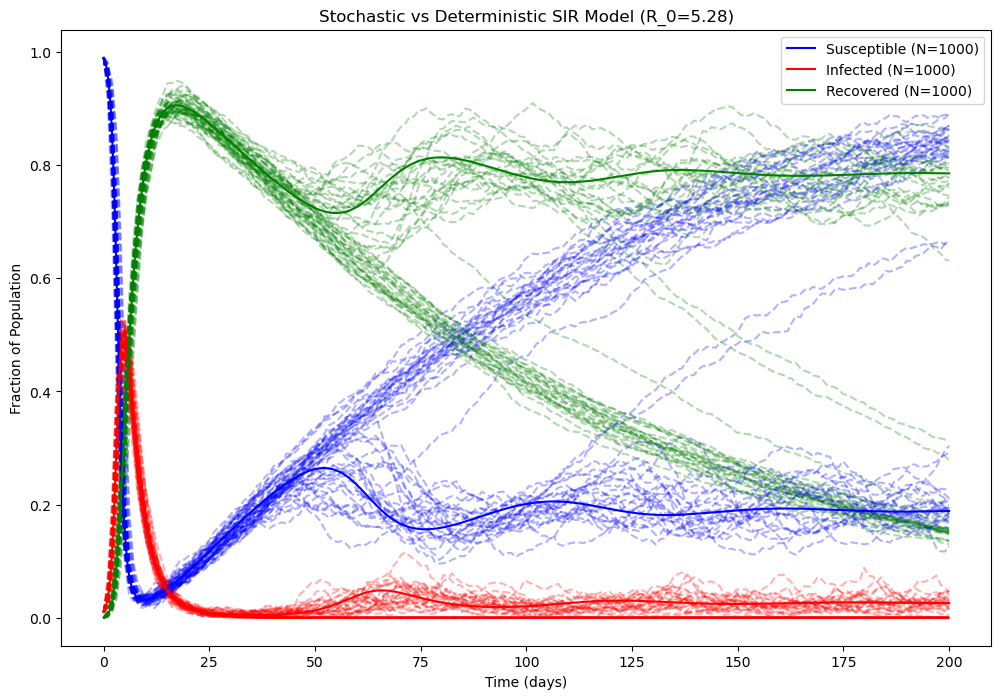

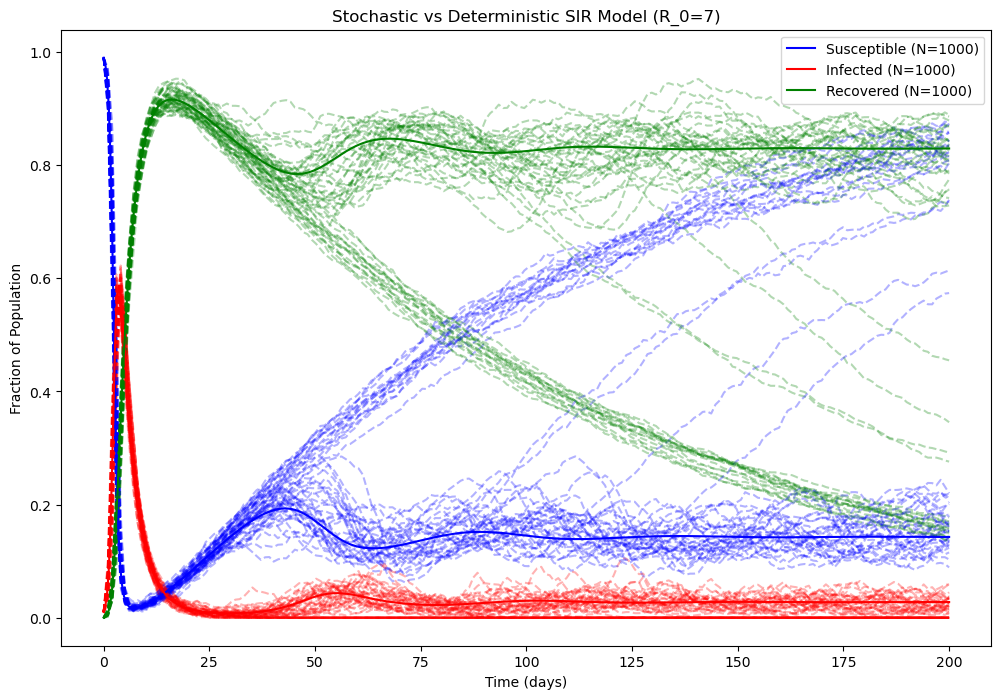

In [19]:
# Function to calculate beta from R_0
def calculate_beta(R_0, gamma, mu):
    return R_0 * (gamma + mu)

# Function to compare stochastic Gillespie simulation and deterministic SIR model
def compare_stochastic_deterministic(SIR_model, SIR_state, SIR_params, R_0_vals, N_vals, max_days=160, num_simulations=50, steps=500):
    gamma = SIR_params['gamma']
    mu = SIR_params['mu']
    
    for R_0 in R_0_vals:
        beta = calculate_beta(R_0, gamma, mu)
        SIR_params['beta'] = beta
        plt.figure(figsize=(12, 8))
        
        # Assign unique colors for S, I, and R
        S_color = 'blue'
        I_color = 'red'
        R_color = 'green'
        
        for idx, N in enumerate(N_vals):
            SIR_state[0] = N - 10  # Update initial susceptible population
            SIR_state[1] = 10      # Set initial infected population
            SIR_state[2] = 0       # Set initial recovered population

            # Store individual stochastic runs
            for simulation in range(num_simulations):  # Plot num_simulations stochastic runs for each N
                time_stoch, S_stochastic, I_stochastic, R_stochastic = multiple_runs(SIR_model, SIR_state, SIR_params, 1, max_days, steps)  

                # Plot each stochastic run with a lighter color
                lighter_S_color = to_rgba(S_color, alpha=0.3)
                lighter_I_color = to_rgba(I_color, alpha=0.3)
                lighter_R_color = to_rgba(R_color, alpha=0.3)

                # Plot S, I, R for each stochastic run
                plt.plot(time_stoch, S_stochastic[0][0] / N, '--', color=lighter_S_color)
                plt.plot(time_stoch, I_stochastic[0][0] / N, '--', color=lighter_I_color)
                plt.plot(time_stoch, R_stochastic[0][0] / N, '--', color=lighter_R_color)

            # Run deterministic SIR simulation with mu (demography)
            time_det, sol_det = run_deterministic_SIR(SIR_state, beta, SIR_params['gamma'], SIR_params['mu'], max_days)

            # Plot deterministic results (susceptible, infected, recovered) with solid lines
            plt.plot(time_det, sol_det[0] / N, '-', color=S_color, label=f'Susceptible (N={N})')
            plt.plot(time_det, sol_det[1] / N, '-', color=I_color, label=f'Infected (N={N})')
            plt.plot(time_det, sol_det[2] / N, '-', color=R_color, label=f'Recovered (N={N})')

        # Plot settings
        plt.xlabel('Time (days)')
        plt.ylabel('Fraction of Population')
        plt.title(f'Stochastic vs Deterministic SIR Model (R_0={R_0})')
        plot_filename = f"stochastic_vs_deterministic_R0_{R_0}_N_{N}.png"
        plt.savefig(plot_filename)
        plt.legend()
        plt.show()

# Parameters for exploration of stochastic resonance and transients
R_0_vals = [1.5, 2.5,5.28, 7]   # R_0 values to explore
N_vals = [1000]              # Population sizes to explore
max_days = 200              # Duration of the simulation
num_simulations = 50        # Number of stochastic runs for the mean
steps = 200                 # Time steps for interpolation in stochastic runs

# Use the compare_stochastic_deterministic function to run the experiments
SIR_params = {
    'gamma': 0.3,    # Recovery rate
    'mu': 1 / 100    # Birth/death rate, e.g., average lifespan of 100 years
}

SIR_state = [990, 10, 0]  # Initial populations: 990 susceptible, 10 infected, 0 recovered
compare_stochastic_deterministic(SIR_model, SIR_state, SIR_params, R_0_vals, N_vals, max_days, num_simulations, steps)

#### code to vary different parameters
##### If you want to vary beta instead of mu call it with different range: 
##### beta_range = np.arange(0.1, 1.0, 0.1) 
##### explore_transients(SIR_model, SIR_state, SIR_params, beta_range, N_range, 'beta', max_days=100, num_simulations=50, steps=200)

0
1
2
3


/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


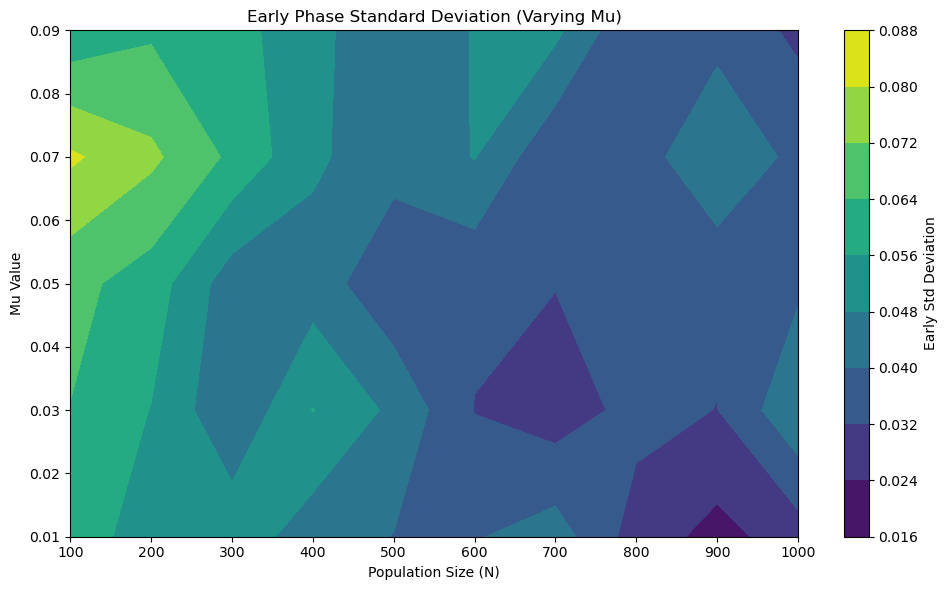

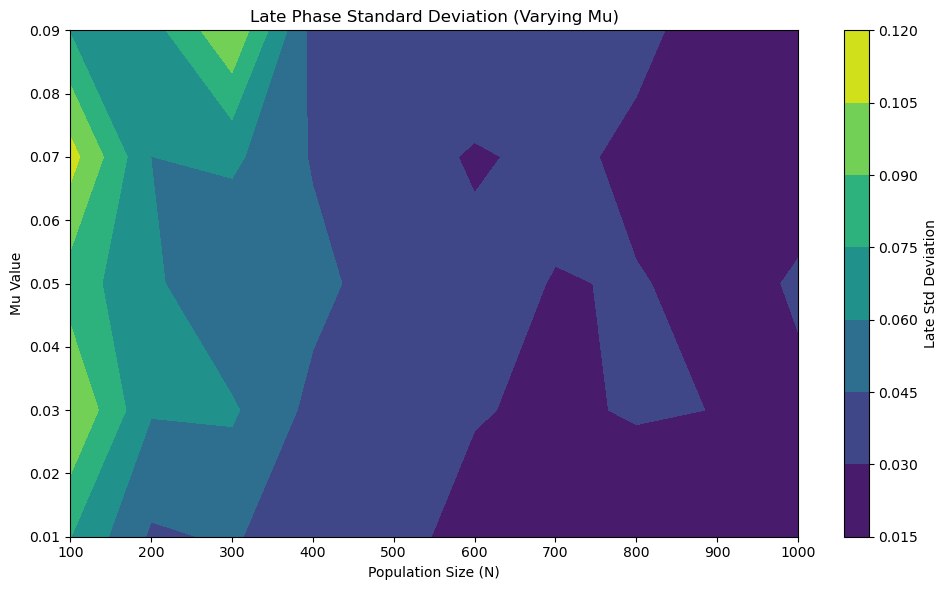

In [20]:
def calculate_mean_difference_and_std(stochastic_results, deterministic_result, deterministic_time, stochastic_time, split_index, N):

    interpolated_stochastic_runs = []
    for run in stochastic_results:
        interp_S = interp1d(stochastic_time, run[0], bounds_error=False, fill_value='extrapolate')
        interp_I = interp1d(stochastic_time, run[1], bounds_error=False, fill_value='extrapolate')
        interp_R = interp1d(stochastic_time, run[2], bounds_error=False, fill_value='extrapolate')

        S_interp = interp_S(deterministic_time)
        I_interp = interp_I(deterministic_time)
        R_interp = interp_R(deterministic_time)
        interpolated_stochastic_runs.append([S_interp, I_interp, R_interp])

    interpolated_stochastic_runs = np.array(interpolated_stochastic_runs)  # Shape: (num_simulations, 3, len(deterministic_time))

    # Early phase: Mean and standard deviation, normalized by N
    early_phase_diffs = np.mean(np.abs((interpolated_stochastic_runs[:, :, :split_index] - deterministic_result[:, :split_index]) / N), axis=0)
    early_std = np.std(interpolated_stochastic_runs[:, :, :split_index] / N, axis=0)
    
    # Late phase: Mean and standard deviation, normalized by N
    late_phase_diffs = np.mean(np.abs((interpolated_stochastic_runs[:, :, split_index:] - deterministic_result[:, split_index:]) / N), axis=0)
    late_std = np.std(interpolated_stochastic_runs[:, :, split_index:] / N, axis=0)


    # Mean absolute differences (averaged over S, I, and R for both early and late phases)
    early_mean_diff = np.mean(early_phase_diffs)
    late_mean_diff = np.mean(late_phase_diffs)

    # Standard deviations (averaged over S, I, and R for both early and late phases)
    early_mean_std = np.mean(early_std)
    late_mean_std = np.mean(late_std)

    return early_mean_diff, late_mean_diff, early_mean_std, late_mean_std


def explore_transients(SIR_model, SIR_state, SIR_params, param_range, N_range, param_name, max_days=100, num_simulations=50, steps=100):
    gamma = SIR_params['gamma']
    mu = SIR_params['mu']
    beta = SIR_params['beta']

    # Split the time in half for early and late phase analysis
    split_time = max_days // 2

    # Create matrices to hold results for early/late mean differences and standard deviations
    early_mean_diff_matrix = np.zeros((len(param_range), len(N_range)))
    late_mean_diff_matrix = np.zeros((len(param_range), len(N_range)))
    early_std_matrix = np.zeros((len(param_range), len(N_range)))
    late_std_matrix = np.zeros((len(param_range), len(N_range)))

    for i, param_value in enumerate(param_range):
        # Adjust the parameter based on what is being varied
        if param_name == 'mu':
            SIR_params['mu'] = param_value
        elif param_name == 'beta':
            SIR_params['beta'] = param_value
        elif param_name == 'gamma':
            SIR_params['gamma'] = param_value

        for j, N in enumerate(N_range):
            SIR_state[0] = N - 10  # Susceptible population
            SIR_state[1] = 10      # Infected population
            SIR_state[2] = 0       # Recovered population

            stochastic_runs = []
            time_stoch = None  # Placeholder for stochastic time array

            # Run stochastic simulations
            for simulation in range(num_simulations):
                time_stoch, S_stoch, I_stoch, R_stoch = multiple_runs(SIR_model, SIR_state, SIR_params, 1, max_days, steps)
                stochastic_runs.append([S_stoch[0][0], I_stoch[0][0], R_stoch[0][0]])  # Store single stochastic run

            # Run deterministic SIR simulation
            time_det, sol_det = run_deterministic_SIR(SIR_state, SIR_params['beta'], SIR_params['gamma'], SIR_params['mu'], max_days)

            # Calculate the index to split time array in half for early and late phases
            split_index = np.searchsorted(time_det, split_time)

            # Calculate mean differences and standard deviations, passing N as well
            early_mean_diff, late_mean_diff, early_std, late_std = calculate_mean_difference_and_std(
                stochastic_runs, sol_det, time_det, time_stoch, split_index, N
            )

            # Store the results
            early_mean_diff_matrix[i, j] = early_mean_diff
            late_mean_diff_matrix[i, j] = late_mean_diff
            early_std_matrix[i, j] = early_std
            late_std_matrix[i, j] = late_std

    # Early phase standard deviations
    X, Y = np.meshgrid(N_range, param_range)
    fig, ax = plt.subplots(figsize=(10, 6))
    contour_filled = ax.contourf(X, Y, early_std_matrix, cmap='viridis')
    fig.colorbar(contour_filled, ax=ax, label='Early Std Deviation')
    ax.set_title(f'Early Phase Standard Deviation (Varying {param_name.capitalize()})')
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel(f'{param_name.capitalize()} Value')
    plt.tight_layout()
    plt.show()

    # Late phase standard deviations
    fig, ax = plt.subplots(figsize=(10, 6))
    contour_filled = ax.contourf(X, Y, late_std_matrix, cmap='viridis')
    fig.colorbar(contour_filled, ax=ax, label='Late Std Deviation')
    ax.set_title(f'Late Phase Standard Deviation (Varying {param_name.capitalize()})')
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel(f'{param_name.capitalize()} Value')
    plt.tight_layout()
    plt.show()


# Define the ranges for the parameter (mu, beta, or gamma) and N
mu_range = np.arange(0.01, 0.1, 0.02)  # Example range for mu
N_range = np.arange(100, 1100, 100)      # Range for population sizes

# Set constant beta and gamma, vary mu
SIR_params = {
    'beta': 0.3,  # Constant beta
    'gamma': 0.1,  # Constant gamma
    'mu': 0.02     # Initial mu (but will vary in the range)
}

# Use the explore_transients function to run the experiments and create the contour plots for varying mu
explore_transients(SIR_model, SIR_state, SIR_params, mu_range, N_range, 'mu', max_days=100, num_simulations=10, steps=100)

# If you want to vary beta instead of mu call it with different range:
# beta_range = np.arange(0.1, 1.0, 0.1)
# explore_transients(SIR_model, SIR_state, SIR_params, beta_range, N_range, 'beta', max_days=100, num_simulations=50, steps=200)


In [ ]:
def calculate_mean_difference_and_std(stochastic_results, deterministic_result, deterministic_time, stochastic_time, split_index, N):
    """
    Calculate the mean absolute difference and standard deviation between the stochastic
    and deterministic results, split into early and late phases.
    """
    # Interpolate stochastic results to match deterministic time steps
    interpolated_stochastic_runs = []
    for run in stochastic_results:
        interp_S = interp1d(stochastic_time, run[0], bounds_error=False, fill_value='extrapolate')
        interp_I = interp1d(stochastic_time, run[1], bounds_error=False, fill_value='extrapolate')
        interp_R = interp1d(stochastic_time, run[2], bounds_error=False, fill_value='extrapolate')

        S_interp = interp_S(deterministic_time)
        I_interp = interp_I(deterministic_time)
        R_interp = interp_R(deterministic_time)
        interpolated_stochastic_runs.append([S_interp, I_interp, R_interp])

    interpolated_stochastic_runs = np.array(interpolated_stochastic_runs)  # Shape: (num_simulations, 3, len(deterministic_time))

    # Early phase: Mean and standard deviation, normalized by N
    early_phase_diffs = np.mean(np.abs((interpolated_stochastic_runs[:, :, :split_index] - deterministic_result[:, :split_index]) / N), axis=0)
    early_std = np.std(interpolated_stochastic_runs[:, :, :split_index] / N, axis=0)
    
    # Late phase: Mean and standard deviation, normalized by N
    late_phase_diffs = np.mean(np.abs((interpolated_stochastic_runs[:, :, split_index:] - deterministic_result[:, split_index:]) / N), axis=0)
    late_std = np.std(interpolated_stochastic_runs[:, :, split_index:] / N, axis=0)


    # Mean absolute differences (averaged over S, I, and R for both early and late phases)
    early_mean_diff = np.mean(early_phase_diffs)
    late_mean_diff = np.mean(late_phase_diffs)

    # Standard deviations (averaged over S, I, and R for both early and late phases)
    early_mean_std = np.mean(early_std)
    late_mean_std = np.mean(late_std)

    return early_mean_diff, late_mean_diff, early_mean_std, late_mean_std


def explore_transients(SIR_model, SIR_state, SIR_params, R_0_range, N_range, max_days=100, num_simulations=50, steps=200):
    gamma = SIR_params['gamma']
    mu = SIR_params['mu']

    # Split the time in half for early and late phase analysis
    split_time = max_days // 2

    # Create matrices to hold results for early/late mean differences and standard deviations
    early_mean_diff_matrix = np.zeros((len(R_0_range), len(N_range)))
    late_mean_diff_matrix = np.zeros((len(R_0_range), len(N_range)))
    early_std_matrix = np.zeros((len(R_0_range), len(N_range)))
    late_std_matrix = np.zeros((len(R_0_range), len(N_range)))

    for i, R_0 in enumerate(R_0_range):
        beta = calculate_beta(R_0, gamma, mu)
        SIR_params['beta'] = beta

        for j, N in enumerate(N_range):
            SIR_state[0] = N - 10  
            SIR_state[1] = 10     
            SIR_state[2] = 0     

            stochastic_runs = []
            time_stoch = None 

            # Run stochastic simulations
            for simulation in range(num_simulations):
                time_stoch, S_stoch, I_stoch, R_stoch = multiple_runs(SIR_model, SIR_state, SIR_params, 1, max_days, steps)
                stochastic_runs.append([S_stoch[0][0], I_stoch[0][0], R_stoch[0][0]])  # Store single stochastic run

            # Run deterministic SIR simulation
            time_det, sol_det = run_deterministic_SIR(SIR_state, beta, SIR_params['gamma'], SIR_params['mu'], max_days)

            # Calculate the index to split time array in half for early and late phases
            split_index = np.searchsorted(time_det, split_time)

            # Calculate mean differences and standard deviations, passing N as well
            early_mean_diff, late_mean_diff, early_std, late_std = calculate_mean_difference_and_std(
                stochastic_runs, sol_det, time_det, time_stoch, split_index, N
            )

            # Store the results
            early_mean_diff_matrix[i, j] = early_mean_diff
            late_mean_diff_matrix[i, j] = late_mean_diff
            early_std_matrix[i, j] = early_std
            late_std_matrix[i, j] = late_std

    # Early phase standard deviations
    X, Y = np.meshgrid(N_range, R_0_range)
    fig, ax = plt.subplots(figsize=(10, 6))
    contour_filled = ax.contourf(X, Y, early_std_matrix, cmap='viridis')
    fig.colorbar(contour_filled, ax=ax, label='Early Std Deviation')
    ax.set_title('Early Phase Standard Deviation of Stochastic Runs')
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel('Basic Reproduction Number (R0)')
    plt.tight_layout()
    plt.show()

    # Late phase standard deviations
    fig, ax = plt.subplots(figsize=(10, 6))
    contour_filled = ax.contourf(X, Y, late_std_matrix, cmap='viridis')
    fig.colorbar(contour_filled, ax=ax, label='Late Std Deviation')
    ax.set_title('Late Phase Standard Deviation of Stochastic Runs')
    ax.set_xlabel('Population Size (N)')
    ax.set_ylabel('Basic Reproduction Number (R0)')
    plt.tight_layout()
    plt.show()


# Define the ranges for R_0 and N
R_0_range = np.arange(1.5, 8.5, 0.5)
N_range = np.arange(50, 1100, 50)

# Use the explore_transients function to run the experiments and create the contour plots
explore_transients(SIR_model, SIR_state, SIR_params, R_0_range, N_range, max_days=100, num_simulations=50, steps=200)


/var/folders/3v/6kq_73ns7j57377v07xc6t_40000gn/T/ipykernel_5665/3999031418.py:28: RuntimeWarning: divide by zero encountered in divide
  delta_t = -np.log(u) / np.array(list(rates.values()))


In [ ]:
import timeit
start_time = timeit.default_timer()


class GillespieFirstReactions:
    def __init__(self, discrete_event_model: dict, initial_state, model_parameters: dict):
        self.model = discrete_event_model
        self.state = initial_state
        self.N = np.sum(initial_state)
        self.model_parameters = model_parameters

        # Track Evolution of Algorithm
        self.day = 0
        self.times = [self.day]
        self.history = [list(initial_state)]
        self.extinct = False  # To track extinction events

    def step(self):
        if self.state[1] == 0:  # Check if Y = 0 (no more infected individuals)
            self.extinct = True  # Mark extinction
            return  # Stop simulation

        rates = self.update_rates()

        u = np.random.uniform(0, 1, size=len(rates))
        delta_t = -np.log(u) / np.array(list(rates.values()))

        min_index = np.argmin(delta_t)
        event = list(rates.keys())[min_index]

        self.day += delta_t[min_index]

        effect = self.model[event][1]
        self.state = [x + dx for x, dx in zip(self.state, effect)]

        self.times.append(self.day)
        self.history.append(list(self.state))

    def run(self, max_days=100):
        while self.day < max_days and not self.extinct:
            self.step()

        # Return time, history, and extinction status
        return self.times, self.history, self.extinct
        
    def update_rates(self):
        S, I, R = self.state
    
        rates = {}
        for event, (rate, effect) in self.model.items():
            rates[event] = rate(S, I, R, self.N, **self.model_parameters)
        return rates

def extinction_experiment(SIR_model, gamma, R0_values, N_values, num_simulations, max_days):
    results = []

    for R0 in R0_values:
        beta = R0 * gamma  
        for N in N_values:
            extinction_count = 0
            extinction_times = []

            for _ in range(num_simulations):
                
                I0 = 10 / N  # Start with 10 infected individuals
                S0 = 1 - I0  # Rest are susceptible
                init_state = [S0 * N, 0.1*(I0 * N), 0]  # [S, I, R]
                
                # Run stochastic SIR model
                model_parameters = {'beta': beta, 'gamma': gamma, 'mu': 0}
                model = GillespieFirstReactions(SIR_model, init_state, model_parameters)
                times, history, extinct = model.run(max_days=max_days)

                if extinct:
                    extinction_count += 1
                    extinction_times.append(times[-1])  # Record the time of extinction

            # Calculate extinction probability and mean time to extinction
            extinction_prob = extinction_count / num_simulations
            mean_time_to_extinction = np.mean(extinction_times) if extinction_times else max_days

            results.append({
                'R0': R0,
                'N': N,
                'extinction_prob': extinction_prob,
                'mean_time_to_extinction': mean_time_to_extinction
            })

    return results

def plot_extinction_results(results):
    # Create two subplots: one for extinction probability, one for time to extinction
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Get unique R0 values and use a colormap to assign colors to the lines
    R0_values = sorted(set([result['R0'] for result in results]))
    color_map = cm.get_cmap('Blues', len(R0_values))  # Use the "Blues" colormap

    # Extinction probability plot
    for i, r0 in enumerate(R0_values):
        ns = [result['N'] for result in results if result['R0'] == r0]
        extinction_probs = [result['extinction_prob'] for result in results if result['R0'] == r0]
        axs[0].plot(ns, extinction_probs, label=f'R0 = {r0}', color=color_map(i))  # Assign color
    
    axs[0].set_xlabel('Population Size (N)')
    axs[0].set_ylabel('Extinction Probability')
    axs[0].set_title('Extinction Probability vs Population Size for Different R0')
    axs[0].legend()

    # Time to extinction plot
    for i, r0 in enumerate(R0_values):
        ns = [result['N'] for result in results if result['R0'] == r0]
        times = [result['mean_time_to_extinction'] for result in results if result['R0'] == r0]
        axs[1].plot(ns, times, label=f'R0 = {r0}', color=color_map(i))  # Assign color
    
    axs[1].set_xlabel('Population Size (N)')
    axs[1].set_ylabel('Mean Time to Extinction (days)')
    axs[1].set_title('Time to Extinction vs Population Size for Different R0')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Experiment parameters
gamma = 0.3  # Recovery rate
R0_values = np.arange(1, 2.1, 0.1).tolist()
R0_values_rounded = [round(val, 1) for val in R0_values]
N_values = [10, 50, 100,150, 200, 250, 300, 400, 500, 600, 750]  # Different population sizes
num_simulations = 500  # Number of simulations per (R0, N)
max_days = 40  # Maximum time for each simulation

# Run extinction experiment
results = extinction_experiment(SIR_model, gamma, R0_values_rounded, N_values, num_simulations, max_days)

# Plot the results
plot_extinction_results(results)
elapsed = timeit.default_timer() - start_time
print(elapsed)

In [ ]:
def plot_extinction_contour(results):
    # Extract unique R0 and N values
    R0_values = sorted(set([result['R0'] for result in results]))
    N_values = sorted(set([result['N'] for result in results]))

    # Create 2D grid of extinction probabilities
    extinction_prob_grid = np.zeros((len(N_values), len(R0_values)))

    for result in results:
        R0_index = R0_values.index(result['R0'])
        N_index = N_values.index(result['N'])
        extinction_prob_grid[N_index, R0_index] = result['extinction_prob']

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Contour and filled contour plot
    levels = np.linspace(0, 1, 50)  # Set levels for contourf and contour
    c = ax.contourf(R0_values, N_values, extinction_prob_grid, levels=levels, cmap='plasma')  # Filled contour plot
    contours = ax.contour(R0_values, N_values, extinction_prob_grid, levels=10, colors='black', linewidths=0.5)  # Contour lines
    ax.clabel(contours, inline=True, fontsize=8)  # Label contour lines

    # Add color bar
    fig.colorbar(c, ax=ax, label='Extinction Probability')

    # Set axis labels and title
    ax.set_xlabel('R0')
    ax.set_ylabel('Population Size (N)')
    ax.set_title('Extinction Probability Contour Plot')

    plt.tight_layout()
    plt.show()

plot_extinction_contour(results)

def plot_mean_time_contour(results):
    # Extract unique R0 and N values
    R0_values = sorted(set([result['R0'] for result in results]))
    N_values = sorted(set([result['N'] for result in results]))

    # Create 2D grid of mean time to extinction
    mean_time_grid = np.zeros((len(N_values), len(R0_values)))

    for result in results:
        R0_index = R0_values.index(result['R0'])
        N_index = N_values.index(result['N'])
        mean_time_grid[N_index, R0_index] = result['mean_time_to_extinction']

    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Contour and filled contour plot
    levels = np.linspace(np.min(mean_time_grid), np.max(mean_time_grid), 50)  # Set levels for contourf and contour
    c = ax.contourf(R0_values, N_values, mean_time_grid, levels=levels, cmap='viridis')  # Filled contour plot
    contours = ax.contour(R0_values, N_values, mean_time_grid, levels=10, colors='black', linewidths=0.5)  # Contour lines
    ax.clabel(contours, inline=True, fontsize=8)  # Label contour lines

    # Add color bar
    fig.colorbar(c, ax=ax, label='Mean Time to Extinction (days)')

    # Set axis labels and title
    ax.set_xlabel('R0')
    ax.set_ylabel('Population Size (N)')
    ax.set_title('Mean Time to Extinction Contour Plot')

    plt.tight_layout()
    plt.show()

plot_mean_time_contour(results)


##### We can see in the first plot that even when $R_0 $is greater than 1, stochastic fluctuations dominate, leading to a high chance of disease extinction. In smaller populations, the number of susceptible and infected individuals is low, which increases the likelihood that all infected individuals will recover before spreading the disease to new hosts. This makes extinction almost certain for all $R_0 $ values when the population size is small.

##### As the population size increases, the random effects become less dominant, and the dynamics are more likely to reflect the deterministic nature of the model, where $R_0 > 1 $means that, on average, each infected person will infect more than one other person. This allows the disease to persist and spread, which explains why the extinction probability decreases as N increases.

##### For larger $R_0 $ values, the disease spreads more easily, meaning that even in larger populations, the infection is more likely to persist. In contrast, when $R_0 $ is smaller, the disease has a harder time sustaining itself, so the extinction probability drops rapidly as N increases, reaching zero for large populations where random fluctuations are less significant and the disease can spread effectively. When $R_0$is close to 1, the disease spreads weakly and is sensitive to random events, so even in large populations, there's still a significant chance (around 20%) that the disease will die out by chance.

##### For the second plot we see that for small population sizes the the mean time to extinction is small and increases rapidly with increasing population size where for bigger $R_0 $ values it increases less fast than for smaller values of $R_0$. For values that are close to 1 it first increases rapidly with increasing N and then after N = 500 it decreases again this happens because, at larger N (with $R_0$ close to 1) becomes more prone to stochastic extinction as it fails to maintain a chain of infections. Even though there are more people to infect, the slow spread means that random recoveries can still cause the disease to die out more quickly in some cases, leading to a decrease in extinction time after reaching a certain population threshold.

In [ ]:

def plot_extinction_heatmap(results, metric="extinction_prob"):
    # Create grid for R0 and N values
    R0_values = sorted(set([result['R0'] for result in results]))
    N_values = sorted(set([result['N'] for result in results]))

    # Prepare a 2D matrix for the heatmap
    heatmap_data = np.zeros((len(N_values), len(R0_values)))

    # Fill the matrix with the selected metric (extinction probability or time to extinction)
    for result in results:
        R0_index = R0_values.index(result['R0'])
        N_index = N_values.index(result['N'])
        heatmap_data[N_index, R0_index] = result[metric]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, xticklabels=R0_values, yticklabels=N_values, cmap="coolwarm", annot=True)
    plt.title(f"{'Extinction Probability' if metric == 'extinction_prob' else 'Mean Time to Extinction'}")
    plt.xlabel('R0')
    plt.ylabel('Population Size (N)')
    plt.show()


plot_extinction_heatmap(results, metric="extinction_prob")  # Extinction probability heatmap
plot_extinction_heatmap(results, metric="mean_time_to_extinction")  # Time to extinction heatmap
